# Task 3 — Heart Disease Prediction: Classification Workflow



## Problem Statement & Goal

Use the UCI Heart Disease dataset to build a binary classifier that predicts presence of heart disease. Perform EDA, preprocessing, model training, evaluation (accuracy, ROC-AUC), and present final insights.

## Environment Setup



`heart.csv` taken from Kaggle.

In [3]:
!pip install --quiet pandas numpy scikit-learn matplotlib seaborn imbalanced-learn

## Load Dataset & EDA



Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



Target distribution:
target
1    165
0    138
Name: count, dtype: int64


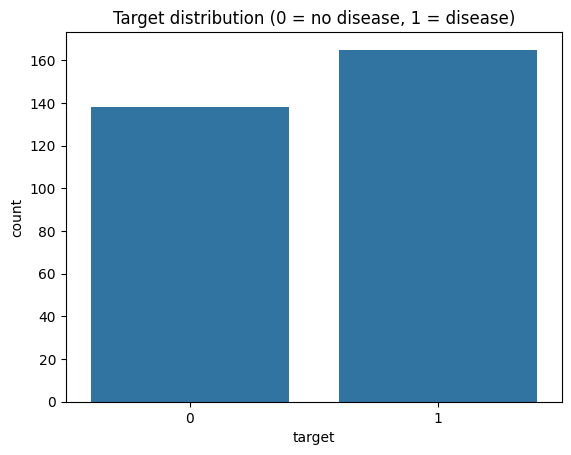

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

# Load dataset (ensure file is available in the session)

try:
    df = pd.read_csv('heart.csv')
except Exception as e:
    print('Could not find heart.csv in the working directory. Please upload the dataset to Colab. Error:', e)
    df = None

if df is not None:
    print('Shape:', df.shape)
    display(df.head())
    print('\nTarget distribution:')
    print(df['target'].value_counts())
    sns.countplot(x='target', data=df)
    plt.title('Target distribution (0 = no disease, 1 = disease)')
    plt.show()

## Preprocessing & Modeling



In [5]:
if df is not None:
    # Handle missing values if any
    print('Missing values:\n', df.isna().sum())
    df = df.fillna(df.median())

    # One-hot encode categorical columns if present
    X = df.drop(columns=['target'])
    y = df['target']
    X = pd.get_dummies(X, drop_first=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg = LogisticRegression(max_iter=500)
    logreg.fit(X_train_scaled, y_train)

    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_train, y_train)

    # Evaluate
    y_pred_lr = logreg.predict(X_test_scaled)
    y_proba_lr = logreg.predict_proba(X_test_scaled)[:,1]
    y_pred_dt = dt.predict(X_test)
    y_proba_dt = dt.predict_proba(X_test)[:,1]

    print('Logistic Regression accuracy:', accuracy_score(y_test, y_pred_lr))
    print('Decision Tree accuracy      :', accuracy_score(y_test, y_pred_dt))
    print('\nClassification report (LogReg):')
    print(classification_report(y_test, y_pred_lr))

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Logistic Regression accuracy: 0.8032786885245902
Decision Tree accuracy      : 0.7868852459016393

Classification report (LogReg):
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61



## Evaluation Visuals & Feature Importance



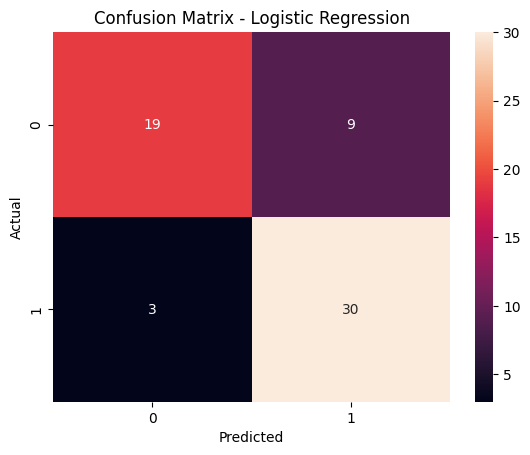

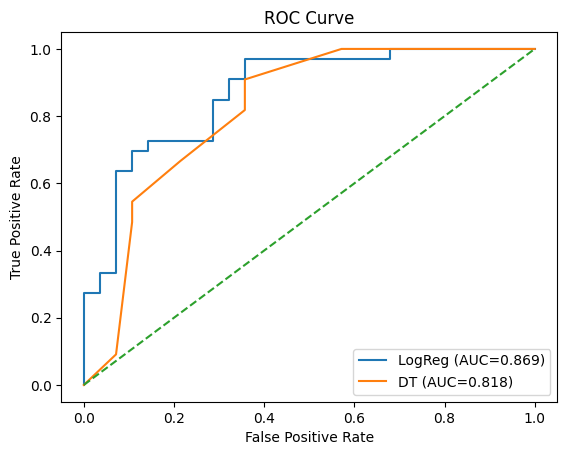

,0
cp,0.937735
sex,0.714030
thal,0.621578
oldpeak,0.594819
ca,0.559203
thalach,0.539629
exang,0.475883
chol,0.459210
slope,0.307867
restecg,0.235471


,0
cp,0.386753
oldpeak,0.166862
thal,0.116889
ca,0.076041
slope,0.053878
thalach,0.049646
trestbps,0.047794
age,0.040760
chol,0.033360
sex,0.028018


In [6]:
if df is not None:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_lr)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
    auc = roc_auc_score(y_test, y_proba_lr)
    plt.plot(fpr, tpr, label=f'LogReg (AUC={auc:.3f})')
    fpr2, tpr2, _ = roc_curve(y_test, y_proba_dt)
    auc2 = roc_auc_score(y_test, y_proba_dt)
    plt.plot(fpr2, tpr2, label=f'DT (AUC={auc2:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Feature importance
    coef = pd.Series(abs(logreg.coef_[0]), index=X.columns).sort_values(ascending=False)
    display(coef.head(10))

    feat_imp = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(feat_imp.head(10))

## Results & Final Insights



**Key takeaways:**

- Report accuracy and AUC; discuss class balance and clinical caution.
- Important features (example): max heart rate, chest pain type, ST depression (`oldpeak`).

**Final insight:** The model provides a baseline; for deployment use cross-validation, calibration, and consult a domain expert for interpretation.

---

**Summary of Model Insights**

- Logistic Regression shows strong weight on oldpeak, cp, and thalach.
- Decision Tree importance often prioritizes oldpeak, ca, thal, and cp.
- Features related to exercise stress test performance (oldpeak, slope, thalach) are especially important.